

```
# 코드로 형식 지정됨
```

# DL(CNN) 과제 자료

출처: https://github.com/chengyangfu/pytorch-vgg-cifar10

VGG16 cifar10 모델을 정확도 40까지 훈련시켜보세요!

In [1]:
import torch
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import time

In [2]:
# DON'T TOUCH
from torchvision import models

model = models.vgg16(weights=None)
model = model.cuda()
print(model)
# DON'T TOUCH

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
# DON'T TOUCH
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)
# DON'T TOUCH

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
# DON'T TOUCH
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res
# DON'T TOUCH

In [5]:
# DON'T TOUCH
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
# DON'T TOUCH

In [6]:
# DON'T TOUCH
criterion = nn.CrossEntropyLoss().cuda()
# DON'T TOUCH

In [8]:
#TODO: Learning rate scheduler! VERY IMPORTANT
def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate decay"""
    
    lr = lr / 2
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [9]:
#TODO: MOST IMPORTANT
lr = 0.005

#TODO: 만약 더 공부하고 싶으면 각 요소들의 의미가 무엇인지 알아보면 좋습니다.
# 더 공부하고 싶지 않으면 아무것도 설정하지 않고 기본값으로도 과제를 끝낼 수 있습니다!
optimizer = torch.optim.SGD(model.parameters(), lr,
                            weight_decay = 0,
                            momentum = 0,
                            nesterov= False
                            )

In [10]:
# DON'T TOUCH
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end =time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        input = input.cuda()
        target = target.cuda()


        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0: 
          print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
# DON'T TOUCH

In [11]:
# DON'T TOUCH
for epoch in range(10):
  adjust_learning_rate(optimizer, epoch, lr)
  # train for one epoch
  train(train_loader, model, criterion, optimizer, epoch)
# DON'T TOUCH

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0][0/782]	Time 7.152 (7.152)	Data 0.287 (0.287)	Loss 6.9073 (6.9073)	Prec@1 0.000 (0.000)
Epoch: [0][10/782]	Time 0.058 (0.708)	Data 0.000 (0.027)	Loss 6.8726 (6.8859)	Prec@1 0.000 (0.284)
Epoch: [0][20/782]	Time 0.059 (0.399)	Data 0.000 (0.014)	Loss 6.8179 (6.8660)	Prec@1 4.688 (1.414)
Epoch: [0][30/782]	Time 0.061 (0.289)	Data 0.000 (0.010)	Loss 6.7222 (6.8370)	Prec@1 10.938 (3.478)
Epoch: [0][40/782]	Time 0.059 (0.233)	Data 0.000 (0.007)	Loss 6.4111 (6.7774)	Prec@1 10.938 (5.107)
Epoch: [0][50/782]	Time 0.059 (0.199)	Data 0.000 (0.006)	Loss 3.1956 (6.4654)	Prec@1 4.688 (5.790)
Epoch: [0][60/782]	Time 0.057 (0.176)	Data 0.000 (0.005)	Loss 3.1440 (5.8792)	Prec@1 6.250 (6.634)
Epoch: [0][70/782]	Time 0.058 (0.159)	Data 0.000 (0.004)	Loss 2.6287 (5.4291)	Prec@1 9.375 (7.350)
Epoch: [0][80/782]	Time 0.059 (0.147)	Data 0.000 (0.004)	Loss 2.6214 (5.0850)	Prec@1 9.375 (7.774)
Epoch: [0][90/782]	Time 0.057 (0.137)	Data 0.000 (0.004)	Loss 2.4754 (4.8095)	Prec@1 6.250 (8.053)
Epoch: [0

In [12]:
# DON'T TOUCH
def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        input = input.cuda()
        target = target.cuda()

        # compute output
        with torch.no_grad():
            output = model(input)
            loss = criterion(output, target)

        output = output.float()
        loss = loss.float()

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses,
                      top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg
# DON'T TOUCH

## 모델 학습 결과 확인!
10 epoch만 train을 해서 완성된 모델의 accuracy가 40이 넘은 장면을 캡쳐해서 올려주세요!

In [13]:
# DON'T TOUCH
validate(val_loader,model,criterion)
# DON'T TOUCH

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test: [0/79]	Time 0.334 (0.334)	Loss 1.3022 (1.3022)	Prec@1 53.906 (53.906)
Test: [10/79]	Time 0.026 (0.064)	Loss 1.3575 (1.3500)	Prec@1 49.219 (49.290)
Test: [20/79]	Time 0.028 (0.048)	Loss 1.4623 (1.3607)	Prec@1 44.531 (49.182)
Test: [30/79]	Time 0.032 (0.043)	Loss 1.3695 (1.3610)	Prec@1 50.000 (49.723)
Test: [40/79]	Time 0.028 (0.040)	Loss 1.3707 (1.3517)	Prec@1 50.000 (49.905)
Test: [50/79]	Time 0.036 (0.039)	Loss 1.4538 (1.3615)	Prec@1 43.750 (49.663)
Test: [60/79]	Time 0.027 (0.038)	Loss 1.2265 (1.3574)	Prec@1 53.906 (49.590)
Test: [70/79]	Time 0.028 (0.037)	Loss 1.4344 (1.3572)	Prec@1 46.875 (49.505)
 * Prec@1 49.600


49.6

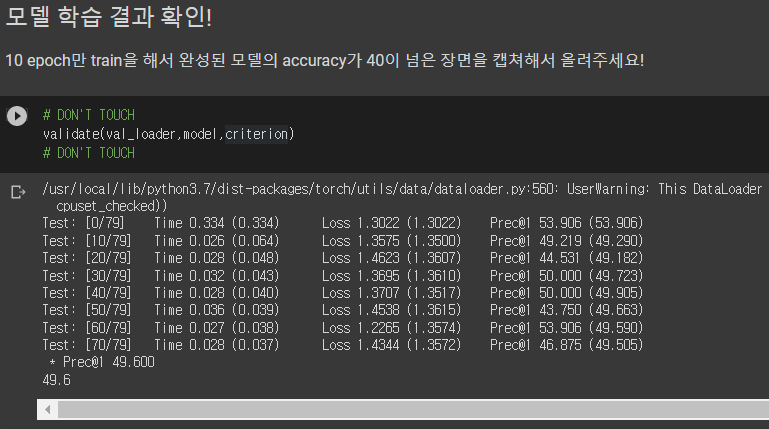

In [ ]:
아자아자 49.6